In [17]:
import os
import re
from operator import itemgetter
from textwrap import dedent
from typing import List

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import seaborn as sns
from datasets import load_dataset
from dotenv import load_dotenv
from edgar import Company, CompanyFiling, CompanyFilings, set_identity
from langchain.schema import Document
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough
from langchain_community.vectorstores import SupabaseVectorStore
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langsmith import Client as LangsmithClient
from langsmith.evaluation import LangChainStringEvaluator, evaluate
from rich import print
from supabase.client import Client, create_client

load_dotenv()
os.environ["LANGCHAIN_PROJECT"] = "llm-evals"
%load_ext rich

The rich extension is already loaded. To reload it, use:
  %reload_ext rich


## Load and embed documents

In [2]:
set_identity("lazy@lazyg.com")

[09:11:08] INFO     Identity of the Edgar REST client set to [lazy@lazyg.com]                           ]8;id=75813;file://e:\Projects\AI-Maven\AIE3\.venv\Lib\site-packages\edgar\core.py\core.py]8;;\:]8;id=350005;file://e:\Projects\AI-Maven\AIE3\.venv\Lib\site-packages\edgar\core.py#147\147]8;;\

In [3]:
def filter_filings(filings: CompanyFilings, year: int):
    """
    Filter filings by form and year.

    :param filings: List of EntityFilings.
    :param form: The form to filter by.
    :param year: The year to filter by.
    :return: The filtered EntityFiling.
    """
    for filing in filings:
        year_of_filing = filing.filing_date.year
        if year_of_filing == year:
            return filing

    raise ValueError(f"No filing found for year {year}.")


In [4]:
def get_items(filing: CompanyFiling, item_names: List[str] = None):
    """
    Get the items from a filing. If no items are specified, all items are returned.

    :param filing: The filing to get items from.
    :param item_names: The items to get.

    :return: The items from the filing.
    """
    items = {} if item_names is not None else {item: filing[item] for item in filing.items}

    if item_names:
        for item in item_names:
            matched_items = [
                filing_item
                for filing_item in filing.items
                if filing_item.lower() == item.lower()
            ]
            if matched_items:
                items[item] = filing[matched_items[0]]
            else:
                raise ValueError(f"Item '{item}' not found in filing.")

    # Remove any newline characters, trim outer whitespace, and remove unwanted patterns
    pattern1 = r"-{3,}|\.{3,}"
    pattern2 = r"\+{2,}"

    cleaned_items = {}

    for key, value in items.items():
        cleaned_value = re.sub(
            pattern2, "", re.sub(pattern1, "", value.replace("\n", " ").strip())
        )
        cleaned_items[key] = cleaned_value

    return cleaned_items

In [5]:
def get_company_items(
    ticker: str, year: int, form: str = "10-K", item_names: List[str] = None
):
    """
    Get the items from a company's filing.

    :param ticker: The company's ticker.
    :param year: The year to filter by.
    :param form: The form to filter by.
    :param item_names: The items to get.

    :return: The items from the company's filing.
    """

    company = Company(ticker)
    filings = company.get_filings(form=form)
    filing = filter_filings(filings, year).obj()
    items = get_items(filing, item_names)

    return items

In [6]:
def chunk_items(items: List[str], ticker: str, year: int, chunk_size:int = 1024, chunk_overlap = 100):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

    documents = []

    for item_name, item in items.items():
        chunks = text_splitter.split_text(item)
    
        chunks = [
            Document(
                page_content=chunk,
                metadata={"item_name": item_name, "ticker": ticker, "year": year},
            )
            for chunk in chunks
        ]

        documents.extend(chunks)

    return documents

In [7]:
supabase_url = os.environ.get("SUPABASE_URL")
supabase_key = os.environ.get("SUPABASE_PRIVATE_KEY")
supabase: Client = create_client(supabase_url, supabase_key)

embeddings = OpenAIEmbeddings(model="text-embedding-3-small", dimensions=512)

vectorstore = SupabaseVectorStore(
    supabase, embedding=embeddings, table_name="documents", query_name="match_documents"
)

#### Load 10-Ks into database

In [8]:
# ticker = "LULU"
# year = 2023

In [9]:
# items = get_company_items(ticker, year, form="10-K", item_names=["Item 1", "Item 7"])
# documents = chunk_items(items, ticker, year)
# _ = vectorstore.add_documents(documents)

## Building the Q/A chain

In [10]:
system_prompt = dedent(
"""
You are a question-answer assistant for company annual reports. 

Given the user's question and relevant context from the annual reports, answer the question. Think step-by-step, and provide a clear and concise answer.
"""
)

question_prompt = dedent(
    """
Context:
{context}

Question:
{question}
"""
)


prompt = ChatPromptTemplate.from_messages(
    [("system", system_prompt), ("human", question_prompt)]
)


prompt


ChatPromptTemplate(
    input_variables=['context', 'question'],
    messages=[
        SystemMessagePromptTemplate(
            prompt=PromptTemplate(
                input_variables=[],
                template="\nYou are a question-answer assistant for company annual reports. \n\nGiven the user's question and relevant context from the annual reports, answer the question. Think step-by-step, and provide a clear and concise answer.\n"
            )
        ),
        HumanMessagePromptTemplate(
            prompt=PromptTemplate(
                input_variables=['context', 'question'],
                template='\nContext:\n{context}\n\nQuestion:\n{question}\n'
            )
        )
    ]
)

In [11]:
llm = ChatOpenAI(model="gpt-4o", temperature=0.6)

retriever = RunnableLambda(
    lambda x: vectorstore.as_retriever(
        search_kwargs={"k": 10, "filter": {"ticker": x["ticker"]}}
    ).invoke(x["question"])
)

chain = (
    {"context": retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"answer": prompt | llm | StrOutputParser(), "contexts": itemgetter("context")}
)

In [12]:
# question = "What is the company's policy on inventories?"
# print(chain.invoke({"question": question, "ticker": "COST"}))

## Financial-10K dataset

Downloaded from HuggingFace: [Source](https://huggingface.co/datasets/virattt/financial-qa-10K)

In [13]:
tickers_loaded = ['NVDA', 'LULU', 'AAPL', 'MSFT', 'COST', 'TSLA']

In [14]:
ds = load_dataset("virattt/financial-qa-10K")["train"].to_pandas()

ds = ds[ds["ticker"].isin(tickers_loaded)]

sampled_ds = ds.sample(n=50, random_state=42)

In [15]:
sampled_ds

,question,answer,context,ticker,filing
110,What are the key factors contributing to Apple...,Key factors contributing to Apple's success in...,The Company’s ability to compete successfully ...,AAPL,2023_10K
519,How many hourly employees completed the superv...,"In 2023, over 7,800 hourly employees completed...","In 2023, over 7,800 hourly employees completed...",COST,2023_10K
765,What percentage growth did LinkedIn revenue ex...,LinkedIn revenue grew by 10%.,•LinkedIn revenue increased $1.3 billion or 10...,MSFT,2023_10K
77,What was the major factor contributing to the ...,The increase was mainly driven by increased co...,"The increase in sales, general and administrat...",NVDA,2023_10K
181,What type of situations will the company recor...,The company will record a liability when it is...,results. Legal and Other Contingencies The Com...,AAPL,2023_10K
284,What caused the drastic change in the provisio...,The drastic change in the provision for income...,Our (benefit from) provision for income taxes ...,TSLA,2023_10K
10,What is the H100 GPU designed to accelerate?,The H100 GPU is designed to accelerate applica...,H100 is ideal for accelerating applications su...,NVDA,2023_10K
569,How many shares were repurchased in 2023 and a...,"1,341,000 shares were repurchased in 2023 at a...","During 2023 and 2022, we repurchased 1,341,000...",COST,2023_10K
78,How did the interest income change in fiscal y...,The interest income increased by 821% in fisca...,Interest income | $ | 267 | | | $ | 29 | | $ |...,NVDA,2023_10K
349,What were the components of the increase in co...,The costs related to operating channels increa...,•an increase in costs related to our operating...,LULU,2023_10K


### Update LangSmith dataset

In [19]:
ls_client = LangsmithClient()

dataset_name = "10K-huggingface-dataset"
dataset_id = "2223a5b1-3846-42f4-b52f-c0e45042f392"
# dataset = ls_client.create_dataset(
#     dataset_name=dataset_name,
#     description="Sample of questions from 10K dataset on HuggingFace. Link: https://huggingface.co/datasets/virattt/financial-qa-10K"
# )

In [20]:
# ls_client.create_examples(
#     inputs=[{"question": q, "ticker": t} for q,t in zip(sampled_ds['question'], sampled_ds['ticker'])],
#     outputs=[{"answer": a, "contexts": c} for a, c in zip(sampled_ds['answer'], sampled_ds['context'])],
#     dataset_id=dataset_id,
# )

## RAG Evals

### Answer correctness

In [21]:
answer_correctness = LangChainStringEvaluator(
    evaluator="cot_qa",
    prepare_data=lambda run, example: {
        "prediction": run.outputs["answer"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    },
)


### Answer hallucinations

In [22]:
answer_hallucinations = LangChainStringEvaluator(
    "labeled_score_string",
    config={
        "criteria": {
            "accuracy": dedent(
                """Is the assistant's answer grounded in the Ground Truth documentation? 
A score of [[1]] means that the Assistant answer contains is not at all based upon / grounded in the Groun Truth documentation. 
A score of [[5]] means that the Assistant answer contains some information (e.g., a hallucination) that is not captured in the Ground Truth documentation. 
A score of [[10]] means that the Assistant answer is fully based upon the in the Ground Truth documentation."""
            )
        }
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["answer"],
        "reference": example.outputs["contexts"],
        "input": example.inputs["question"],
    },
)


### Document retrieval

In [23]:
document_relevance = LangChainStringEvaluator(
    "score_string",
    config={
        "criteria": {
            "document_relevance": dedent(
                """The response is a set of documents retrieved from a vectorstore. The input is a question used for retrieval. 
You will score whether the Assistant's response (retrieved docs) is relevant to the Ground Truth question. 
A score of [[1]] means that none of the  Assistant's response documents contain information useful in answering or addressing the user's input.
A score of [[5]] means that the Assistant answer contains some relevant documents that can at least partially answer the user's question or input. 
A score of [[10]] means that the user input can be fully answered using the content in the first retrieved doc(s)."""
            )
        }
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["contexts"],
        "input": example.inputs["question"],
    },
)


[09:11:59] WARNING  This chain was only tested with GPT-4. Performance may be significantly worse ]8;id=194607;file://e:\Projects\AI-Maven\AIE3\.venv\Lib\site-packages\langchain\evaluation\scoring\eval_chain.py\eval_chain.py]8;;\:]8;id=746863;file://e:\Projects\AI-Maven\AIE3\.venv\Lib\site-packages\langchain\evaluation\scoring\eval_chain.py#260\260]8;;\
                    with other models.                                                                             

In [ ]:
k_vals = [1, 2, 5, 7, 10, 15]

for k in k_vals:
    print(f'Testing for {k=}')
    llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.6)

    retriever = RunnableLambda(
        lambda x: vectorstore.as_retriever(
        search_kwargs={
            "k": k,
            "filter": {
                'ticker': x['ticker']
            }
        }
    ).invoke(x['question']))

    chain = (
        {
            "context": retriever,
            "question": itemgetter("question")
        }
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | {"answer": prompt | llm | StrOutputParser(), "contexts": itemgetter("context")}
    )

    def get_answer(input):
        response = chain.invoke(input)

        return {
            'answer': response['answer'], 'contexts': response['contexts']
        }

    experiment_result = evaluate(
        get_answer,
        data="10K-huggingface-dataset",
        evaluators=[answer_correctness, answer_hallucinations, document_relevance],
        experiment_prefix=f"10k-hf-50-k{k}",
        num_repetitions=5,
        metadata={
            "model": "openai/gpt-3.5-turbo",
            "temperature": 0.6,
            "embedding": "openai/text-embedding-3-small",
            "vectorstore": "supabase",
            "k": k,
            "embedding_dimensions": 512,
            "chunk_size": 1024,
            "chunk_overlap": 100,
        },
    )

## Analyzing the experiments

In [24]:
experiments = [
    "10k-hf-50-k15-aa1d49ee",
    "10k-hf-50-k1-3c113bf5",
    "10k-hf-50-k2-b4b39f46",
    "10k-hf-50-k5-81350fbd",
    "10k-hf-50-k7-5b177ada",
    "10k-hf-50-k10-6a823655",
    "10k-hf-50-k15-af614853",
    "10k-hf-50-k1-fbfae6f9",
    "10k-hf-50-k2-380bab31",
    "10k-hf-50-k5-b100df83",
    "10k-hf-50-k7-a9931b8c",
    "10k-hf-50-k10-2786a66c",
]

experiment_results = [
    ls_client.read_project(project_name=x, include_stats=True) for x in experiments
]

In [25]:
df = pd.concat(
    [
        pd.json_normalize(
            experiment_results[i].__dict__ for i in range(len(experiment_results))
        )
    ]
)

df

,id,start_time,end_time,description,name,tenant_id,reference_dataset_id,run_count,latency_p50,latency_p99,...,extra.metadata.num_repetitions,extra.metadata.embedding_dimensions,feedback_stats.cot contextual accuracy.n,feedback_stats.cot contextual accuracy.avg,feedback_stats.cot contextual accuracy.values.CORRECT,feedback_stats.cot contextual accuracy.values.INCORRECT,feedback_stats.score_string:accuracy.n,feedback_stats.score_string:accuracy.avg,feedback_stats.score_string:document_relevance.n,feedback_stats.score_string:document_relevance.avg
0,49d7766e-fc84-457f-813d-c2eb4da8672d,2024-06-24 20:40:43.800341,2024-06-24 20:41:45.081853+00:00,None,10k-hf-50-k15-aa1d49ee,b2168712-33fc-552d-9b53-dcb590f913e9,2223a5b1-3846-42f4-b52f-c0e45042f392,250,0 days 00:00:03.429500,0 days 00:00:08.165060,...,5,512,250,0.688000,172,78,250,6.716000,250,8.596
1,c9fda258-5887-460d-a439-799e475639fb,2024-06-24 17:19:50.230496,2024-06-24 17:20:53.974003+00:00,None,10k-hf-50-k1-3c113bf5,b2168712-33fc-552d-9b53-dcb590f913e9,2223a5b1-3846-42f4-b52f-c0e45042f392,250,0 days 00:00:02.905500,0 days 00:00:08.668350,...,5,512,250,0.456000,114,136,250,5.452000,250,6.500
2,2b990af8-8352-4caa-af17-e70074c829c0,2024-06-24 17:25:37.059256,2024-06-24 17:26:37.469226+00:00,None,10k-hf-50-k2-b4b39f46,b2168712-33fc-552d-9b53-dcb590f913e9,2223a5b1-3846-42f4-b52f-c0e45042f392,250,0 days 00:00:02.568500,0 days 00:00:12.497990,...,5,512,250,0.628000,157,93,250,6.432000,250,7.612
3,d00e5826-0c65-4fe2-86cf-9b78a1b618fe,2024-06-24 17:31:34.445589,2024-06-24 17:32:43.698962+00:00,None,10k-hf-50-k5-81350fbd,b2168712-33fc-552d-9b53-dcb590f913e9,2223a5b1-3846-42f4-b52f-c0e45042f392,250,0 days 00:00:02.761000,0 days 00:00:14.536180,...,5,512,250,0.688000,172,78,249,6.939759,250,8.132
4,748dd9bd-7b85-4be5-a122-7b1091455bff,2024-06-24 17:38:15.610123,2024-06-24 17:39:28.071648+00:00,None,10k-hf-50-k7-5b177ada,b2168712-33fc-552d-9b53-dcb590f913e9,2223a5b1-3846-42f4-b52f-c0e45042f392,250,0 days 00:00:02.887500,0 days 00:00:16.318570,...,5,512,250,0.708000,177,73,250,6.908000,250,8.144
5,68c9a581-d904-40fe-a489-6a65a3855139,2024-06-24 17:44:58.998146,2024-06-24 17:46:07.234232+00:00,None,10k-hf-50-k10-6a823655,b2168712-33fc-552d-9b53-dcb590f913e9,2223a5b1-3846-42f4-b52f-c0e45042f392,250,0 days 00:00:02.993500,0 days 00:00:11.994000,...,5,512,250,0.728000,182,68,250,7.024000,250,8.288
6,bfb22f97-a76c-42c1-a663-f2863d23ec03,2024-06-24 17:51:27.770722,2024-06-24 17:52:38.914526+00:00,None,10k-hf-50-k15-af614853,b2168712-33fc-552d-9b53-dcb590f913e9,2223a5b1-3846-42f4-b52f-c0e45042f392,250,0 days 00:00:03.056500,0 days 00:00:13.712610,...,5,512,250,0.736000,184,66,250,7.108000,250,8.568
7,96d5c1e0-c329-4222-9209-b9a6717ba897,2024-06-24 20:08:36.610635,2024-06-24 20:09:30.747037+00:00,None,10k-hf-50-k1-fbfae6f9,b2168712-33fc-552d-9b53-dcb590f913e9,2223a5b1-3846-42f4-b52f-c0e45042f392,250,0 days 00:00:02.773500,0 days 00:00:07.066600,...,5,512,250,0.444000,111,139,250,5.076000,250,6.484
8,e3aa241a-3322-46af-88cf-caa0c22ef86f,2024-06-24 20:15:12.167724,2024-06-24 20:16:14.296832+00:00,None,10k-hf-50-k2-380bab31,b2168712-33fc-552d-9b53-dcb590f913e9,2223a5b1-3846-42f4-b52f-c0e45042f392,250,0 days 00:00:03.501000,0 days 00:00:09.478710,...,5,512,250,0.612000,153,97,250,6.124000,250,7.644
9,3e68facd-2048-4c3f-ae58-678358459c82,2024-06-24 20:21:37.134835,2024-06-24 20:22:33.479289+00:00,None,10k-hf-50-k5-b100df83,b2168712-33fc-552d-9b53-dcb590f913e9,2223a5b1-3846-42f4-b52f-c0e45042f392,250,0 days 00:00:03.071000,0 days 00:00:07.117750,...,5,512,250,0.668000,167,83,250,6.656000,250,8.128


In [26]:
df[
    [
        "feedback_stats.score_string:accuracy.avg",
        "feedback_stats.score_string:document_relevance.avg",
    ]
] = (
    df[
        [
            "feedback_stats.score_string:accuracy.avg",
            "feedback_stats.score_string:document_relevance.avg",
        ]
    ]
    / 10
)


[09:12:12] INFO     Using categorical units to plot a list of strings that are all parsable as      ]8;id=977266;file://e:\Projects\AI-Maven\AIE3\.venv\Lib\site-packages\matplotlib\category.py\category.py]8;;\:]8;id=606329;file://e:\Projects\AI-Maven\AIE3\.venv\Lib\site-packages\matplotlib\category.py#223\223]8;;\
                    floats or dates. If these strings should be plotted as numbers, cast to the                    
                    appropriate data type before plotting.                                                         

           INFO     Using categorical units to plot a list of strings that are all parsable as      ]8;id=693551;file://e:\Projects\AI-Maven\AIE3\.venv\Lib\site-packages\matplotlib\category.py\category.py]8;;\:]8;id=939121;file://e:\Projects\AI-Maven\AIE3\.venv\Lib\site-packages\matplotlib\category.py#223\223]8;;\
                    floats or dates. If these strings should be plotted as numbers, cast to the                    
                    appropriate data type before plotting.                                                         

[09:12:13] INFO     Using categorical units to plot a list of strings that are all parsable as      ]8;id=989646;file://e:\Projects\AI-Maven\AIE3\.venv\Lib\site-packages\matplotlib\category.py\category.py]8;;\:]8;id=590971;file://e:\Projects\AI-Maven\AIE3\.venv\Lib\site-packages\matplotlib\category.py#223\223]8;;\
                    floats or dates. If these strings should be plotted as numbers, cast to the                    
                    appropriate data type before plotting.                                                         

           INFO     Using categorical units to plot a list of strings that are all parsable as      ]8;id=179315;file://e:\Projects\AI-Maven\AIE3\.venv\Lib\site-packages\matplotlib\category.py\category.py]8;;\:]8;id=98823;file://e:\Projects\AI-Maven\AIE3\.venv\Lib\site-packages\matplotlib\category.py#223\223]8;;\
                    floats or dates. If these strings should be plotted as numbers, cast to the                    
                    appropriate data type before plotting.                                                         

           INFO     Using categorical units to plot a list of strings that are all parsable as      ]8;id=135976;file://e:\Projects\AI-Maven\AIE3\.venv\Lib\site-packages\matplotlib\category.py\category.py]8;;\:]8;id=448712;file://e:\Projects\AI-Maven\AIE3\.venv\Lib\site-packages\matplotlib\category.py#223\223]8;;\
                    floats or dates. If these strings should be plotted as numbers, cast to the                    
                    appropriate data type before plotting.                                                         

           INFO     Using categorical units to plot a list of strings that are all parsable as      ]8;id=591539;file://e:\Projects\AI-Maven\AIE3\.venv\Lib\site-packages\matplotlib\category.py\category.py]8;;\:]8;id=97608;file://e:\Projects\AI-Maven\AIE3\.venv\Lib\site-packages\matplotlib\category.py#223\223]8;;\
                    floats or dates. If these strings should be plotted as numbers, cast to the                    
                    appropriate data type before plotting.                                                         

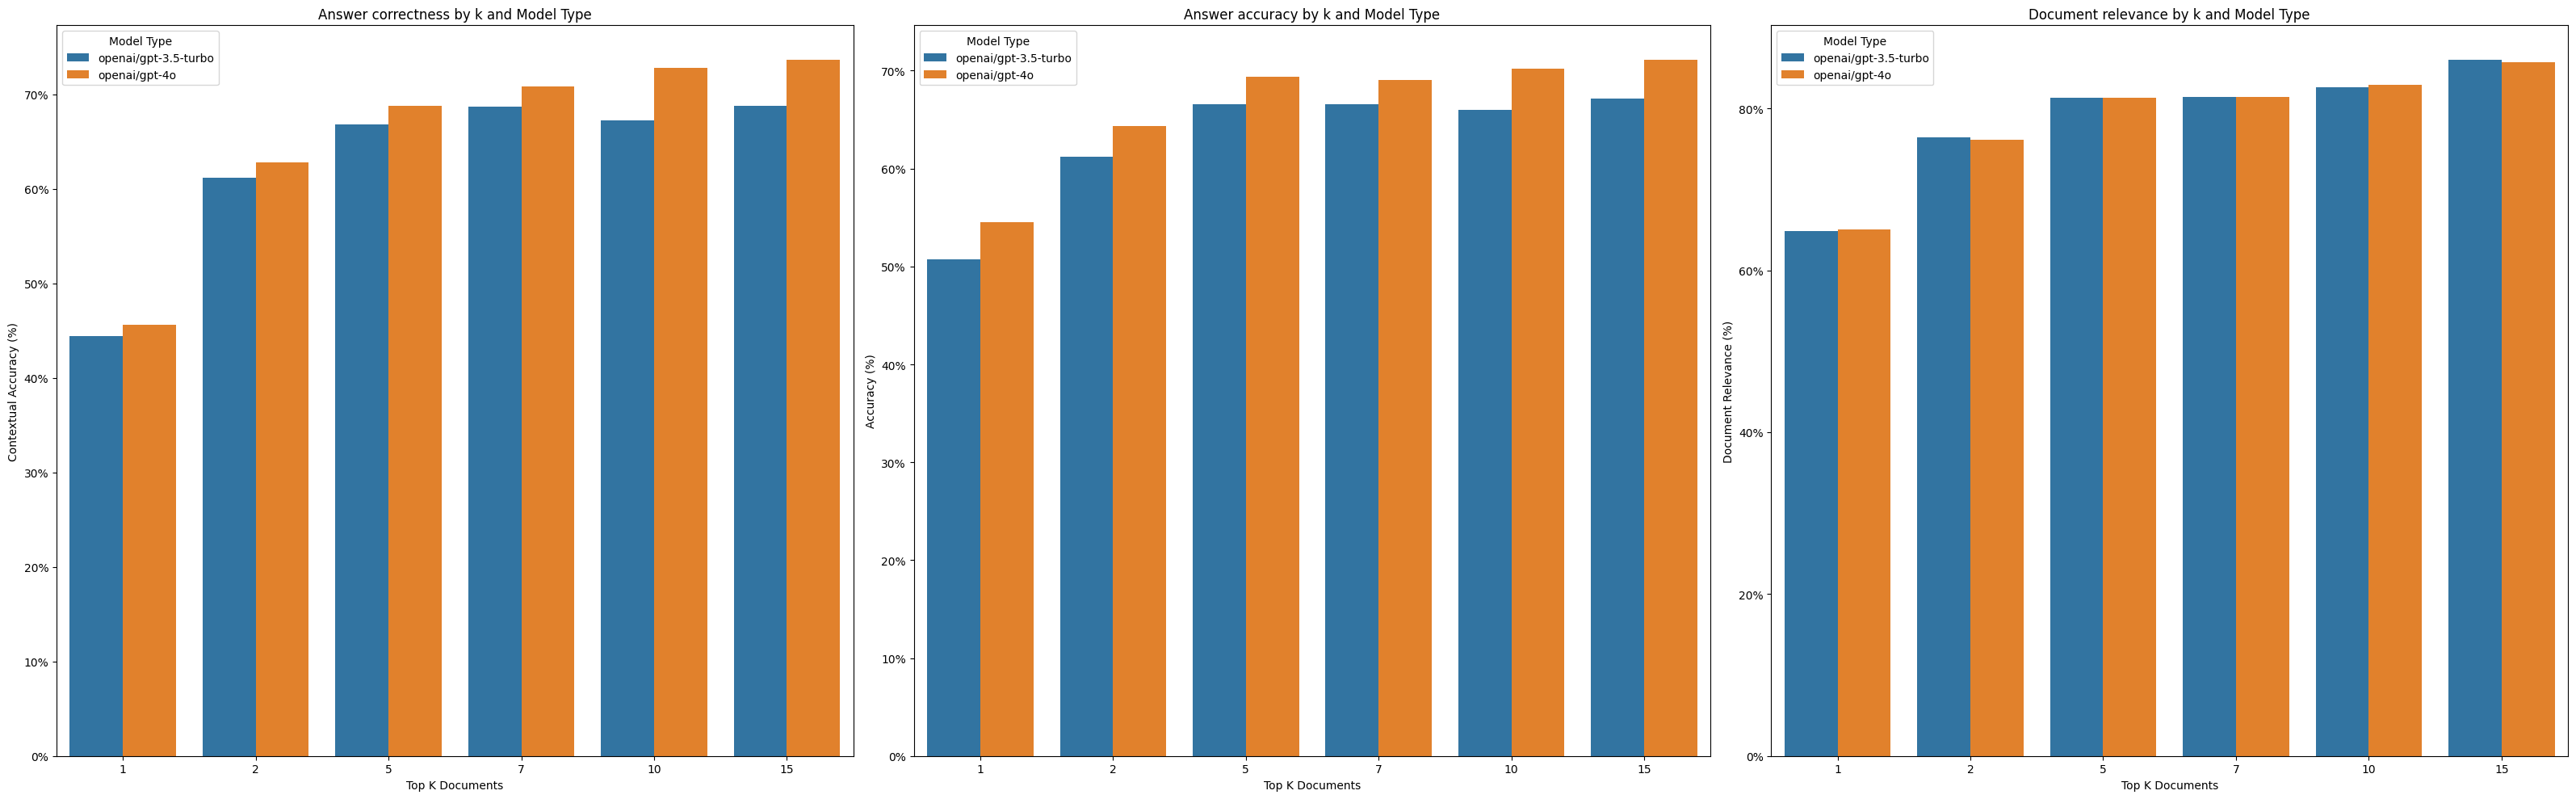

In [27]:
grouped_df = (
    df.groupby(["extra.metadata.model", "extra.metadata.k"])[
        [
            "feedback_stats.cot contextual accuracy.avg",
            "feedback_stats.score_string:accuracy.avg",
            "feedback_stats.score_string:document_relevance.avg",
        ]
    ]
    .mean()
    .reset_index()
)

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(32, 10))

# Plot the bar chart for Contextual Accuracy
sns.barplot(
    data=grouped_df,
    x="extra.metadata.k",
    y="feedback_stats.cot contextual accuracy.avg",
    hue="extra.metadata.model",
    ax=axes[0],
)
axes[0].set_xlabel("Top K Documents")
axes[0].set_ylabel("Contextual Accuracy (%)")
axes[0].set_title("Answer correctness by k and Model Type")
axes[0].legend(title="Model Type")
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Plot the bar chart for Accuracy
sns.barplot(
    data=grouped_df,
    x="extra.metadata.k",
    y="feedback_stats.score_string:accuracy.avg",
    hue="extra.metadata.model",
    ax=axes[1],
)
axes[1].set_xlabel("Top K Documents")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Answer accuracy by k and Model Type")
axes[1].legend(title="Model Type")
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Plot the bar chart for Document Relevance
sns.barplot(
    data=grouped_df,
    x="extra.metadata.k",
    y="feedback_stats.score_string:document_relevance.avg",
    hue="extra.metadata.model",
    ax=axes[2],
)
axes[2].set_xlabel("Top K Documents")
axes[2].set_ylabel("Document Relevance (%)")
axes[2].set_title("Document relevance by k and Model Type")
axes[2].legend(title="Model Type")
axes[2].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Adjust layout
plt.tight_layout()
plt.show()

[09:12:20] INFO     Using categorical units to plot a list of strings that are all parsable as      ]8;id=861568;file://e:\Projects\AI-Maven\AIE3\.venv\Lib\site-packages\matplotlib\category.py\category.py]8;;\:]8;id=86860;file://e:\Projects\AI-Maven\AIE3\.venv\Lib\site-packages\matplotlib\category.py#223\223]8;;\
                    floats or dates. If these strings should be plotted as numbers, cast to the                    
                    appropriate data type before plotting.                                                         

           INFO     Using categorical units to plot a list of strings that are all parsable as      ]8;id=20405;file://e:\Projects\AI-Maven\AIE3\.venv\Lib\site-packages\matplotlib\category.py\category.py]8;;\:]8;id=32780;file://e:\Projects\AI-Maven\AIE3\.venv\Lib\site-packages\matplotlib\category.py#223\223]8;;\
                    floats or dates. If these strings should be plotted as numbers, cast to the                    
                    appropriate data type before plotting.                                                         

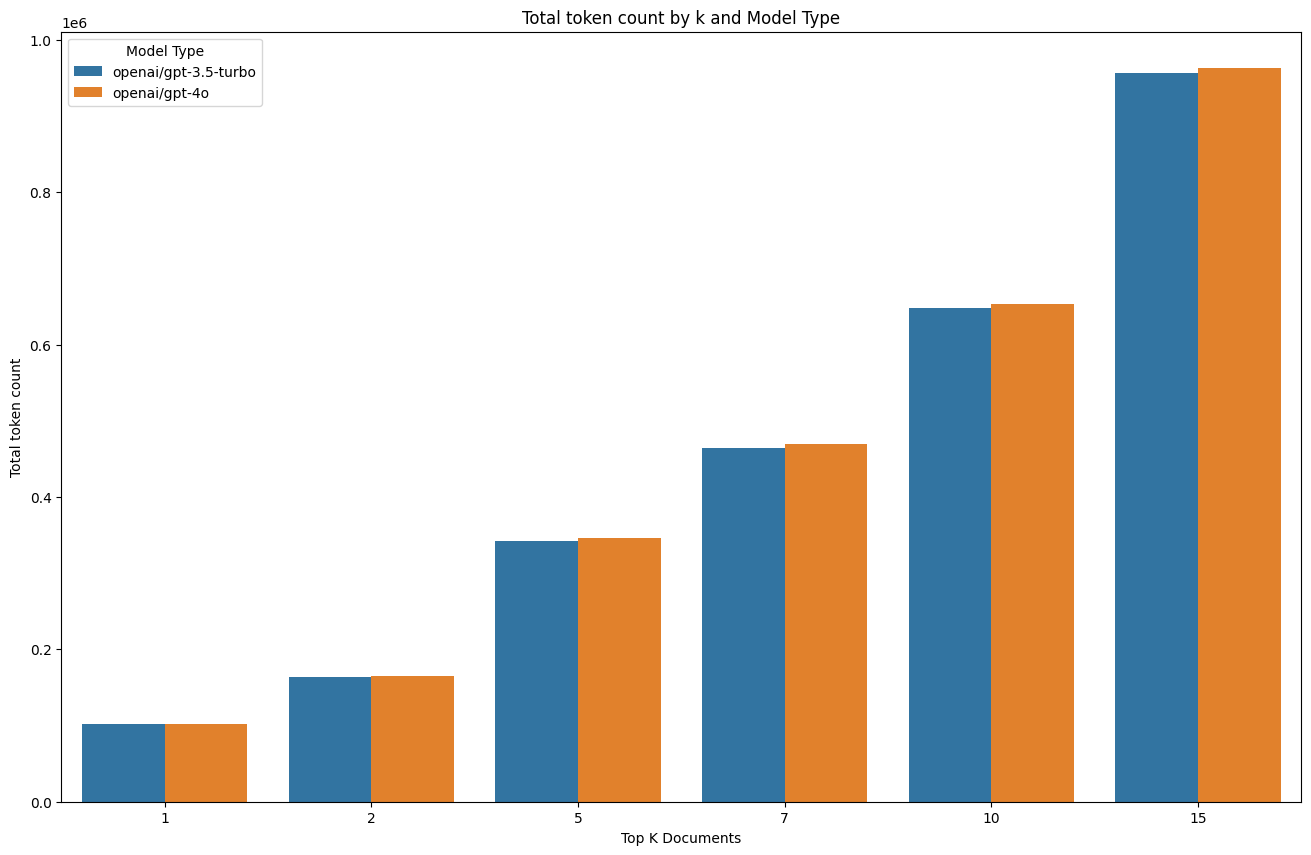

In [28]:
grouped_df = (
    df.groupby(["extra.metadata.model", "extra.metadata.k"])[["total_tokens"]]
    .mean()
    .reset_index()
)

# Create a figure with subplots
fig, ax = plt.subplots(figsize=(16, 10))

# Plot the bar chart for Contextual Accuracy
sns.barplot(
    data=grouped_df,
    x="extra.metadata.k",
    y="total_tokens",
    hue="extra.metadata.model",
    ax=ax,
)
ax.set_xlabel("Top K Documents")
ax.set_ylabel("Total token count")
ax.set_title("Total token count by k and Model Type")
ax.legend(title="Model Type")
plt.show()
